In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

## Dataset Class

In [3]:
import torchvision.transforms as transforms

class ImageDatasetLoad(Dataset):
    def __init__(self, root_dir, train_mode):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        
        self.images = []
        self.labels = []
        path_classes = []
        
        for class_dir in self.classes:
            path_classes.append(os.path.join(root_dir, class_dir))
            
        for i, path in enumerate(path_classes):
            for image_file in os.listdir(path):
                image_path = os.path.join(path, image_file)
                
                try:
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, dsize=(224,224))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    self.images.append(image)
                    self.labels.append(i)
                except RuntimeError:
                    pass
                
        self.train_transforms = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20), 
                                       transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.RandomVerticalFlip(p=0.005), 
                                       transforms.RandomGrayscale(p=0.2), 
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])
        self.test_transforms = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Here we apply the transformations to the pytorch image tensor
        if self.train_mode:
            image = self.train_transforms(image)
        else:
            image = self.test_transforms(image)
        return image, label
    
    def get_class_name(self, class_idx):
        return self.classes[class_idx]

    def get_all_class_names(self):
        return self.classes

                

## Split and Load Dataset

In [4]:
train_dataset = ImageDatasetLoad('/kaggle/input/cats-and-dogs-image-classification/train', train_mode=True)
test_dataset = ImageDatasetLoad('/kaggle/input/cats-and-dogs-image-classification/test', train_mode=False)

In [5]:
test_dataset[0]

(tensor([[[ 0.2706,  0.2471,  0.2706,  ...,  0.2941,  0.3176,  0.3098],
          [ 0.2000,  0.1922,  0.2078,  ...,  0.3412,  0.2706,  0.3647],
          [ 0.2392,  0.2000,  0.3176,  ...,  0.2784,  0.3176,  0.3333],
          ...,
          [ 0.5843,  0.6627,  0.6314,  ...,  0.5373,  0.6078,  0.7176],
          [ 0.5765,  0.6471,  0.6392,  ...,  0.6000,  0.5294,  0.5294],
          [ 0.6314,  0.6863,  0.5216,  ...,  0.7098,  0.4667,  0.5686]],
 
         [[ 0.0824,  0.0667,  0.0824,  ...,  0.1137,  0.1608,  0.1373],
          [ 0.0196,  0.0118,  0.0275,  ...,  0.1686,  0.1137,  0.1922],
          [ 0.0902,  0.0667,  0.1529,  ...,  0.1137,  0.1451,  0.1686],
          ...,
          [ 0.5216,  0.5922,  0.5686,  ...,  0.4353,  0.4980,  0.6078],
          [ 0.5137,  0.5686,  0.5843,  ...,  0.5294,  0.4431,  0.4667],
          [ 0.5608,  0.6157,  0.4745,  ...,  0.6392,  0.3882,  0.4902]],
 
         [[-0.1765, -0.1922, -0.1843,  ..., -0.1529, -0.1137, -0.1529],
          [-0.2471, -0.2314,

In [6]:
print(len(train_dataset), len(test_dataset))

557 140


In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

## Plot some images

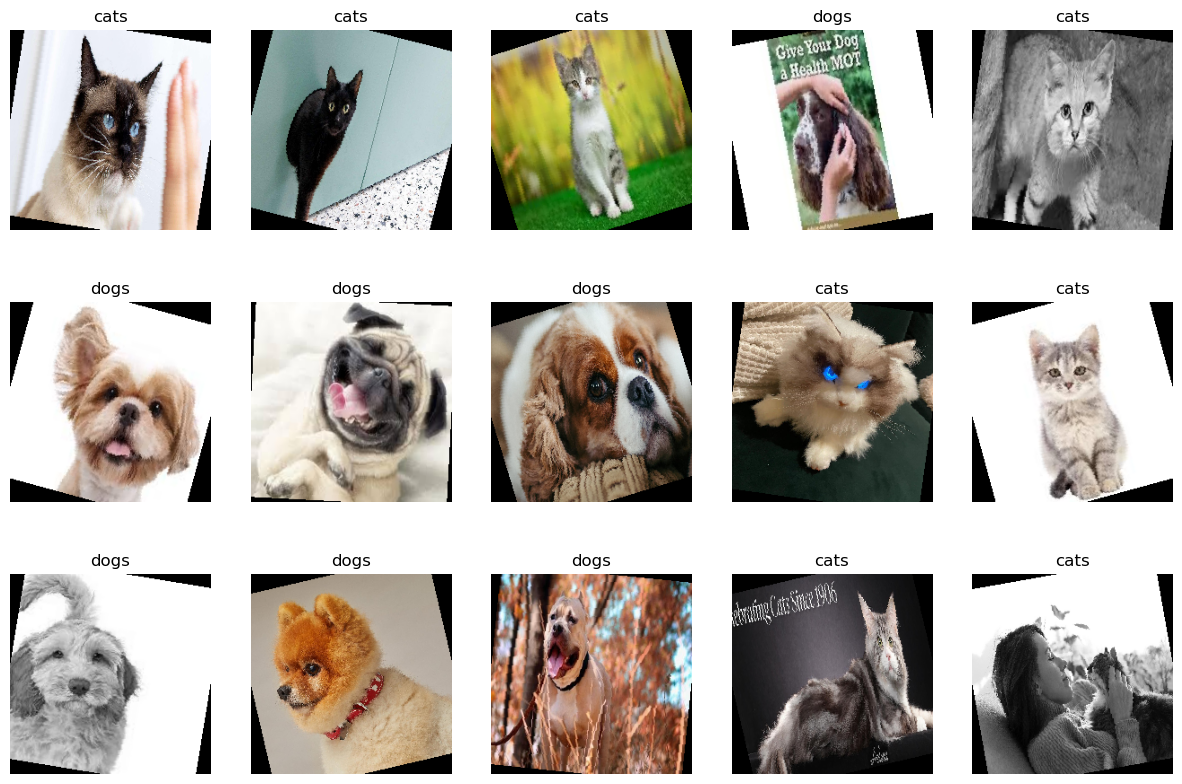

In [8]:
def plot_images(images, labels, class_name):
    plt.figure(figsize=(15, 10))
    num_imgs = min(15, len(images))
    for i in range(num_imgs):
        ax = plt.subplot(3, 5, i+1)
        img = images[i].numpy()
        img = np.transpose(img,(1,2,0))
        
        img -= np.min(img)
        img /= (np.max(img) - np.min(img))
        
        plt.imshow(img)
        plt.title(class_name[labels[i]])
        plt.axis('off')
        
#         break
        
images, labels = next(iter(train_loader))
# print(images, labels)
plot_images(images, labels, ['dogs', 'cats'])

## Set up for Training

In [9]:
import torch
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cpu


## Model Class

In [10]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, device):
        super(CNNModel, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
#             nn.Dropout2d(0.25),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
#             nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
#             nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
#             nn.Dropout(0.25),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128*3*3, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        self.to(device)
        
    def forward(self, x):
        try:
            x = self.cnn_layers(x)
#             print(x.shape)
            x = self.linear_layers(x)
        except RuntimeError:
            print(x.shape)
            pass
        return x

In [11]:
model = CNNModel(device)
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
print(outputs.shape, labels.shape)

torch.Size([16, 1]) torch.Size([16])


## Simple Train and Test Loop

In [12]:
!pip install torchmetrics

In [13]:
import torchmetrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [14]:
model = CNNModel(device)

In [15]:
summary(model, input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 1]                   --
├─Sequential: 1-1                        [32, 128, 3, 3]           --
│    └─Conv2d: 2-1                       [32, 16, 112, 112]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 112, 112]        32
│    └─ReLU: 2-3                         [32, 16, 112, 112]        --
│    └─MaxPool2d: 2-4                    [32, 16, 56, 56]          --
│    └─Conv2d: 2-5                       [32, 32, 28, 28]          4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 28, 28]          64
│    └─ReLU: 2-7                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-8                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-9                       [32, 64, 14, 14]          18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 14, 14]          128
│    └─ReLU: 2-11                        [32, 64, 14, 14]          --
│    └

In [16]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)
metric = torchmetrics.classification.BinaryAccuracy().to(device)

In [17]:
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test).reshape(-1)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [18]:
train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []

for epoch in range(50):
    
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)
        
        # Forward propagation
        train_preds = model(X_train).reshape(-1)
        train_loss = loss_function(train_preds, y_train)
        
#         Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)
            
        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
        
    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|██████████| 35/35 [00:03<00:00,  8.89it/s]


Epoch: 0 	| Train loss: 0.681 	| Test loss: 0.663 	| Train acc: 0.52 	| Test acc: 0.54


100%|██████████| 35/35 [00:03<00:00,  8.97it/s]


Epoch: 1 	| Train loss: 0.687 	| Test loss: 0.75 	| Train acc: 0.6 	| Test acc: 0.53


100%|██████████| 35/35 [00:04<00:00,  8.13it/s]


Epoch: 2 	| Train loss: 0.676 	| Test loss: 0.691 	| Train acc: 0.59 	| Test acc: 0.5


100%|██████████| 35/35 [00:03<00:00,  8.87it/s]


Epoch: 3 	| Train loss: 0.594 	| Test loss: 0.637 	| Train acc: 0.64 	| Test acc: 0.55


100%|██████████| 35/35 [00:03<00:00,  8.90it/s]


Epoch: 4 	| Train loss: 0.612 	| Test loss: 0.727 	| Train acc: 0.57 	| Test acc: 0.61


100%|██████████| 35/35 [00:03<00:00,  8.83it/s]


Epoch: 5 	| Train loss: 0.699 	| Test loss: 0.664 	| Train acc: 0.63 	| Test acc: 0.59


100%|██████████| 35/35 [00:03<00:00,  8.79it/s]


Epoch: 6 	| Train loss: 0.717 	| Test loss: 0.655 	| Train acc: 0.58 	| Test acc: 0.57


100%|██████████| 35/35 [00:03<00:00,  8.90it/s]


Epoch: 7 	| Train loss: 0.65 	| Test loss: 0.641 	| Train acc: 0.6 	| Test acc: 0.61


100%|██████████| 35/35 [00:04<00:00,  8.72it/s]


Epoch: 8 	| Train loss: 0.625 	| Test loss: 0.895 	| Train acc: 0.62 	| Test acc: 0.51


100%|██████████| 35/35 [00:04<00:00,  8.30it/s]


Epoch: 9 	| Train loss: 0.6 	| Test loss: 0.646 	| Train acc: 0.62 	| Test acc: 0.61


100%|██████████| 35/35 [00:03<00:00,  8.96it/s]


Epoch: 10 	| Train loss: 0.7 	| Test loss: 0.591 	| Train acc: 0.61 	| Test acc: 0.58


100%|██████████| 35/35 [00:03<00:00,  9.02it/s]


Epoch: 11 	| Train loss: 0.499 	| Test loss: 0.801 	| Train acc: 0.63 	| Test acc: 0.57


100%|██████████| 35/35 [00:03<00:00,  8.84it/s]


Epoch: 12 	| Train loss: 0.536 	| Test loss: 0.626 	| Train acc: 0.63 	| Test acc: 0.64


100%|██████████| 35/35 [00:03<00:00,  9.05it/s]


Epoch: 13 	| Train loss: 0.621 	| Test loss: 0.411 	| Train acc: 0.69 	| Test acc: 0.61


100%|██████████| 35/35 [00:03<00:00,  8.76it/s]


Epoch: 14 	| Train loss: 0.541 	| Test loss: 0.699 	| Train acc: 0.66 	| Test acc: 0.59


100%|██████████| 35/35 [00:03<00:00,  8.84it/s]


Epoch: 15 	| Train loss: 0.432 	| Test loss: 0.862 	| Train acc: 0.67 	| Test acc: 0.63


100%|██████████| 35/35 [00:03<00:00,  9.03it/s]


Epoch: 16 	| Train loss: 0.601 	| Test loss: 0.481 	| Train acc: 0.69 	| Test acc: 0.66


100%|██████████| 35/35 [00:04<00:00,  7.96it/s]


Epoch: 17 	| Train loss: 0.425 	| Test loss: 0.416 	| Train acc: 0.71 	| Test acc: 0.59


100%|██████████| 35/35 [00:03<00:00,  8.90it/s]


Epoch: 18 	| Train loss: 0.667 	| Test loss: 0.389 	| Train acc: 0.7 	| Test acc: 0.59


100%|██████████| 35/35 [00:03<00:00,  9.05it/s]


Epoch: 19 	| Train loss: 0.558 	| Test loss: 0.438 	| Train acc: 0.72 	| Test acc: 0.61


100%|██████████| 35/35 [00:03<00:00,  8.78it/s]


Epoch: 20 	| Train loss: 0.648 	| Test loss: 0.436 	| Train acc: 0.76 	| Test acc: 0.59


100%|██████████| 35/35 [00:03<00:00,  8.82it/s]


Epoch: 21 	| Train loss: 0.438 	| Test loss: 0.572 	| Train acc: 0.75 	| Test acc: 0.6


100%|██████████| 35/35 [00:03<00:00,  9.06it/s]


Epoch: 22 	| Train loss: 0.391 	| Test loss: 0.316 	| Train acc: 0.75 	| Test acc: 0.59


100%|██████████| 35/35 [00:03<00:00,  8.78it/s]


Epoch: 23 	| Train loss: 0.65 	| Test loss: 0.508 	| Train acc: 0.73 	| Test acc: 0.62


100%|██████████| 35/35 [00:04<00:00,  7.99it/s]


Epoch: 24 	| Train loss: 0.294 	| Test loss: 0.261 	| Train acc: 0.75 	| Test acc: 0.56


100%|██████████| 35/35 [00:04<00:00,  8.66it/s]


Epoch: 25 	| Train loss: 0.862 	| Test loss: 0.366 	| Train acc: 0.74 	| Test acc: 0.66


100%|██████████| 35/35 [00:03<00:00,  8.89it/s]


Epoch: 26 	| Train loss: 0.36 	| Test loss: 0.669 	| Train acc: 0.75 	| Test acc: 0.58


100%|██████████| 35/35 [00:03<00:00,  9.04it/s]


Epoch: 27 	| Train loss: 0.437 	| Test loss: 0.62 	| Train acc: 0.78 	| Test acc: 0.58


100%|██████████| 35/35 [00:03<00:00,  8.95it/s]


Epoch: 28 	| Train loss: 0.347 	| Test loss: 0.727 	| Train acc: 0.76 	| Test acc: 0.67


100%|██████████| 35/35 [00:03<00:00,  8.99it/s]


Epoch: 29 	| Train loss: 0.277 	| Test loss: 0.451 	| Train acc: 0.77 	| Test acc: 0.62


100%|██████████| 35/35 [00:04<00:00,  8.72it/s]


Epoch: 30 	| Train loss: 0.709 	| Test loss: 0.092 	| Train acc: 0.79 	| Test acc: 0.61


100%|██████████| 35/35 [00:03<00:00,  8.75it/s]


Epoch: 31 	| Train loss: 0.719 	| Test loss: 1.14 	| Train acc: 0.78 	| Test acc: 0.62


100%|██████████| 35/35 [00:04<00:00,  8.13it/s]


Epoch: 32 	| Train loss: 0.532 	| Test loss: 0.547 	| Train acc: 0.78 	| Test acc: 0.63


100%|██████████| 35/35 [00:03<00:00,  8.92it/s]


Epoch: 33 	| Train loss: 0.627 	| Test loss: 0.286 	| Train acc: 0.8 	| Test acc: 0.67


100%|██████████| 35/35 [00:03<00:00,  8.96it/s]


Epoch: 34 	| Train loss: 0.411 	| Test loss: 0.461 	| Train acc: 0.8 	| Test acc: 0.66


100%|██████████| 35/35 [00:03<00:00,  8.88it/s]


Epoch: 35 	| Train loss: 0.471 	| Test loss: 0.551 	| Train acc: 0.8 	| Test acc: 0.64


100%|██████████| 35/35 [00:03<00:00,  8.81it/s]


Epoch: 36 	| Train loss: 0.444 	| Test loss: 0.255 	| Train acc: 0.81 	| Test acc: 0.66


100%|██████████| 35/35 [00:03<00:00,  9.07it/s]


Epoch: 37 	| Train loss: 0.606 	| Test loss: 0.609 	| Train acc: 0.82 	| Test acc: 0.61


100%|██████████| 35/35 [00:03<00:00,  8.97it/s]


Epoch: 38 	| Train loss: 0.156 	| Test loss: 0.213 	| Train acc: 0.81 	| Test acc: 0.69


100%|██████████| 35/35 [00:04<00:00,  7.99it/s]


Epoch: 39 	| Train loss: 0.137 	| Test loss: 0.452 	| Train acc: 0.81 	| Test acc: 0.69


100%|██████████| 35/35 [00:03<00:00,  8.93it/s]


Epoch: 40 	| Train loss: 0.501 	| Test loss: 0.487 	| Train acc: 0.84 	| Test acc: 0.66


100%|██████████| 35/35 [00:03<00:00,  8.90it/s]


Epoch: 41 	| Train loss: 0.449 	| Test loss: 0.342 	| Train acc: 0.81 	| Test acc: 0.73


100%|██████████| 35/35 [00:03<00:00,  8.76it/s]


Epoch: 42 	| Train loss: 0.605 	| Test loss: 0.564 	| Train acc: 0.85 	| Test acc: 0.71


100%|██████████| 35/35 [00:03<00:00,  9.14it/s]


Epoch: 43 	| Train loss: 0.351 	| Test loss: 0.499 	| Train acc: 0.83 	| Test acc: 0.72


100%|██████████| 35/35 [00:03<00:00,  8.82it/s]


Epoch: 44 	| Train loss: 0.499 	| Test loss: 0.388 	| Train acc: 0.82 	| Test acc: 0.56


100%|██████████| 35/35 [00:03<00:00,  8.82it/s]


Epoch: 45 	| Train loss: 0.289 	| Test loss: 0.411 	| Train acc: 0.83 	| Test acc: 0.73


100%|██████████| 35/35 [00:03<00:00,  8.88it/s]


Epoch: 46 	| Train loss: 0.775 	| Test loss: 0.384 	| Train acc: 0.83 	| Test acc: 0.64


100%|██████████| 35/35 [00:04<00:00,  7.79it/s]


Epoch: 47 	| Train loss: 0.351 	| Test loss: 0.517 	| Train acc: 0.83 	| Test acc: 0.69


100%|██████████| 35/35 [00:03<00:00,  8.84it/s]


Epoch: 48 	| Train loss: 0.424 	| Test loss: 0.214 	| Train acc: 0.85 	| Test acc: 0.6


100%|██████████| 35/35 [00:03<00:00,  8.76it/s]


Epoch: 49 	| Train loss: 0.29 	| Test loss: 0.5 	| Train acc: 0.85 	| Test acc: 0.68


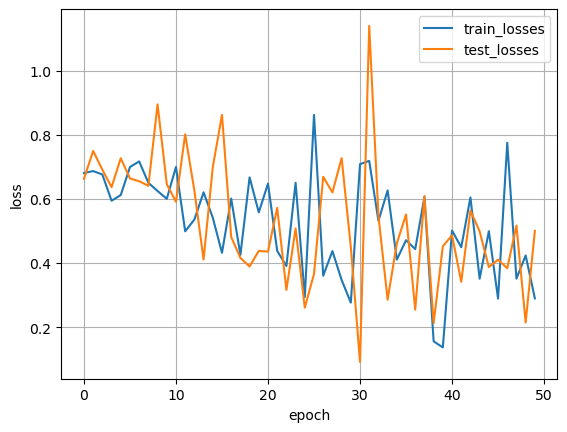

In [19]:
plt.figure()
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

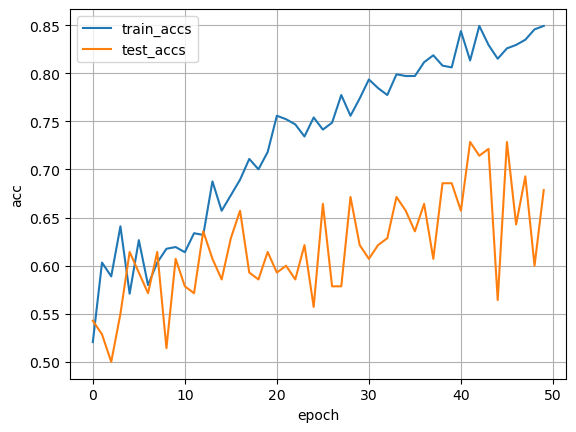

In [20]:
plt.figure()
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()